In [1]:
import sys
sys.path.append("../dataset/")
sys.path.append("../models/segformer")
from datasets import TrainDataset, TestDataset, ValDataset
import transforms as tran
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from train_segformer import train, visualize_example
from transformers import SegformerForSemanticSegmentation
import pandas as pd
import stats

/home/ziereis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_to_results = '../models/segformer/results/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
metrics = [stats.Precision(), stats.Recall(), stats.F2(), stats.DiceScore(), stats.Jac(), stats.Acc(), stats.Confidence(), stats.F1()]


In [3]:
train_for_cal = TrainDataset('../data/', transform=tran.ToTensor())
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
count = len(train_for_cal) * 512 * 512
loader_for_cal = DataLoader(train_for_cal, batch_size=32, shuffle=False)

for inputs, mask in loader_for_cal:
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

t_ms = tran.Compose([
        tran.ToTensor(),
        tran.Normalize(total_mean, total_std)
    ])

In [4]:
losses_train = pd.DataFrame({})
losses_test = pd.DataFrame({})
iou_train = pd.DataFrame({})
iou_test = pd.DataFrame({})

In [5]:
def eval_model(pretrain, name, epoch, t):
    model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/{pretrain}", 
        num_labels=4,
    ).to(device)

    model.load_state_dict(state_dict=torch.load(f'{path_to_results}/{pretrain}_{name}/model_epoch_{epoch}.pth'))
    df = pd.read_csv(f'{path_to_results}/{pretrain}_{name}/training_stats.csv')
    losses_train[f'{pretrain}_{name}'] = df['Train_Loss']
    losses_test[f'{pretrain}_{name}'] = df['Test_Loss']
    iou_train[f'{pretrain}_{name}'] = df['Train_IoU']
    iou_test[f'{pretrain}_{name}'] = df['Test_IoU']

    val = ValDataset('../data/', transform=t, with_background=True)
    val_loader = DataLoader(val, batch_size=1, shuffle=False)
    res = stats.calculate_statistics(model, device, val, val_loader, metrics)
    stats.print_statistics(res, metrics, f'{pretrain}_{name}')
    
t_base = tran.Compose([
        tran.ToTensor(),
    ])

t_05 = tran.Compose([
        tran.ToTensor(),
        tran.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

eval_model('mit-b0', 'norm_base', "30",t_base)
eval_model('mit-b0', 'norm_05', "30",t_05)
eval_model('mit-b0', 'norm_ms', "30",t_ms)
eval_model('mit-b1', 'ms_model', "12",t_ms)
eval_model('mit-b2', 'ms_model', "20",t_ms)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b0_norm_base
	Precision: 0.8410% | ± 0.1220 (std) | ± 0.0149 (var)
	Recall: 0.4652% | ± 0.3264 (std) | ± 0.1066 (var)
	F2: 0.5619% | ± 0.2464 (std) | ± 0.0607 (var)
	DiceScore: 0.6348% | ± 0.2576 (std) | ± 0.0664 (var)
	Jac: 0.6378% | ± 0.2829 (std) | ± 0.0800 (var)
	Acc: 0.6705% | ± 0.2282 (std) | ± 0.0521 (var)
	Confidence: 0.5356% | ± 0.3587 (std) | ± 0.1287 (var)
	F1: 0.6092% | ± 0.2641 (std) | ± 0.0697 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b0_norm_05
	Precision: 0.8103% | ± 0.1194 (std) | ± 0.0143 (var)
	Recall: 0.5906% | ± 0.2445 (std) | ± 0.0598 (var)
	F2: 0.6859% | ± 0.1758 (std) | ± 0.0309 (var)
	DiceScore: 0.6727% | ± 0.2443 (std) | ± 0.0597 (var)
	Jac: 0.6729% | ± 0.2452 (std) | ± 0.0601 (var)
	Acc: 0.7299% | ± 0.1763 (std) | ± 0.0311 (var)
	Confidence: 0.5511% | ± 0.3049 (std) | ± 0.0930 (var)
	F1: 0.7079% | ± 0.1748 (std) | ± 0.0306 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b0_norm_ms
	Precision: 0.8419% | ± 0.0982 (std) | ± 0.0096 (var)
	Recall: 0.5543% | ± 0.2667 (std) | ± 0.0711 (var)
	F2: 0.6476% | ± 0.1927 (std) | ± 0.0371 (var)
	DiceScore: 0.6064% | ± 0.2407 (std) | ± 0.0580 (var)
	Jac: 0.6722% | ± 0.2587 (std) | ± 0.0669 (var)
	Acc: 0.6855% | ± 0.2020 (std) | ± 0.0408 (var)
	Confidence: 0.5430% | ± 0.3322 (std) | ± 0.1104 (var)
	F1: 0.6786% | ± 0.1948 (std) | ± 0.0380 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b1_ms_model
	Precision: 0.8256% | ± 0.1157 (std) | ± 0.0134 (var)
	Recall: 0.5425% | ± 0.2809 (std) | ± 0.0789 (var)
	F2: 0.5527% | ± 0.2417 (std) | ± 0.0584 (var)
	DiceScore: 0.5519% | ± 0.2512 (std) | ± 0.0631 (var)
	Jac: 0.6118% | ± 0.3118 (std) | ± 0.0972 (var)
	Acc: 0.7053% | ± 0.2056 (std) | ± 0.0423 (var)
	Confidence: 0.5502% | ± 0.3052 (std) | ± 0.0931 (var)
	F1: 0.6955% | ± 0.1889 (std) | ± 0.0357 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b2_ms_model
	Precision: 0.8113% | ± 0.1210 (std) | ± 0.0146 (var)
	Recall: 0.6152% | ± 0.2491 (std) | ± 0.0620 (var)
	F2: 0.5759% | ± 0.2280 (std) | ± 0.0520 (var)
	DiceScore: 0.6357% | ± 0.2115 (std) | ± 0.0447 (var)
	Jac: 0.6915% | ± 0.2330 (std) | ± 0.0543 (var)
	Acc: 0.7549% | ± 0.1484 (std) | ± 0.0220 (var)
	Confidence: 0.5810% | ± 0.2880 (std) | ± 0.0830 (var)
	F1: 0.6913% | ± 0.1987 (std) | ± 0.0395 (var)
-----------------------------------


In [9]:
iou_test

,mit-b0_norm_base,mit-b0_norm_05,mit-b0_norm_ms,mit-b1_ms_model,mit-b2_ms_model,mit-b2_sizes_128,mit-b2_sizes_256,mit-b2_lr_0.0001,mit-b2_lr_0.00001,mit-b2_aug_flip_0.0001,mit-b2_aug_flip__HSV_0.0001
0,0.004334,0.366243,0.355028,0.341625,0.117359,0.040790,0.322986,0.515870,0.257647,0.435263,0.181354
1,0.176230,0.589773,0.246771,0.248265,0.381018,0.208266,0.287284,0.520187,0.379481,0.497311,0.214241
2,0.375780,0.520268,0.458812,0.402925,0.582385,0.308509,0.339478,0.588757,0.403432,0.556795,0.216101
3,0.262835,0.389406,0.423965,0.486895,0.446884,0.426670,0.403441,0.647746,0.543874,0.589378,0.513631
4,0.230631,0.407240,0.343375,0.311966,0.483126,0.522142,0.429265,0.506854,0.531427,0.636996,0.196419
5,0.426061,0.302535,0.379810,0.284694,0.646360,0.449617,0.476830,0.572352,0.514190,0.592922,0.410311
6,0.489438,0.546721,0.457930,0.520552,0.478832,0.567842,0.459983,0.587546,0.498712,0.562453,0.305191
7,0.447342,0.607045,0.436297,0.622655,0.548906,0.487767,0.473770,0.592467,0.632299,0.516680,0.416055
8,0.437517,0.531227,0.386641,0.519439,0.609166,0.493977,0.519606,0.639119,0.517037,0.543586,0.468715
9,0.343367,0.498239,0.470069,0.563797,0.565389,0.389882,0.468848,0.674487,0.556847,0.601020,0.540833


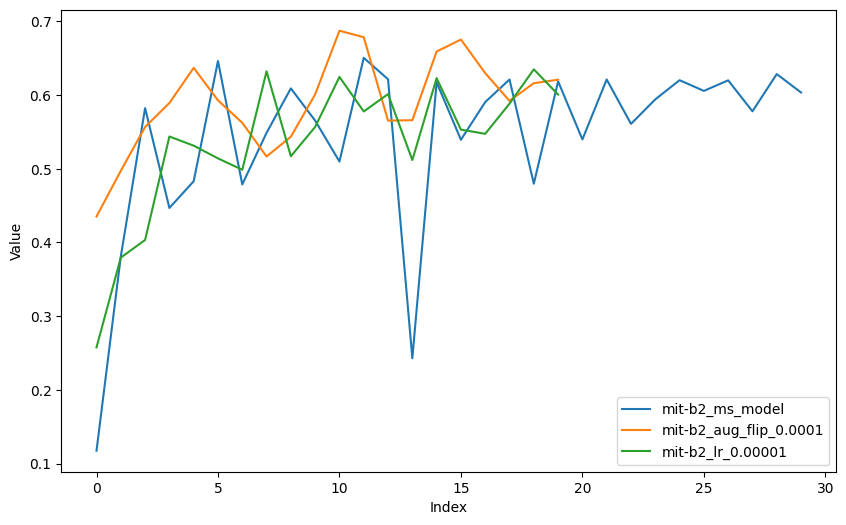

In [14]:
loss_test[['mit-b2_ms_model', 'mit-b2_aug_flip_0.0001', 'mit-b2_lr_0.00001']].plot(figsize=(10,6))

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('')

# Display the plot
plt.show()


In [6]:
eval_model('mit-b2', 'sizes_128', "12", tran.Compose([t_ms, tran.Resize(128)]))
eval_model('mit-b2', 'sizes_256', "20", tran.Compose([t_ms, tran.Resize(256)]))
eval_model('mit-b2', 'lr_0.0001', "12" , t_ms)
eval_model('mit-b2', 'lr_0.00001', '16', t_ms)
eval_model('mit-b2', 'aug_flip_0.0001', "16" , t_ms)
eval_model('mit-b2', 'aug_flip__HSV_0.0001', "24" , t_ms)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b2_sizes_128
	Precision: 0.8727% | ± 0.0799 (std) | ± 0.0064 (var)
	Recall: 0.3661% | ± 0.5057 (std) | ± 0.2557 (var)
	F2: 0.2375% | ± 0.4400 (std) | ± 0.1936 (var)
	DiceScore: 0.2956% | ± 0.3689 (std) | ± 0.1361 (var)
	Jac: 0.2433% | ± 0.4506 (std) | ± 0.2030 (var)
	Acc: 0.4794% | ± 0.3812 (std) | ± 0.1453 (var)
	Confidence: 0.6183% | ± 0.2534 (std) | ± 0.0642 (var)
	F1: 0.6691% | ± 0.2031 (std) | ± 0.0413 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b2_sizes_256
	Precision: 0.8486% | ± 0.0875 (std) | ± 0.0077 (var)
	Recall: 0.4592% | ± 0.3192 (std) | ± 0.1019 (var)
	F2: 0.6225% | ± 0.2440 (std) | ± 0.0595 (var)
	DiceScore: 0.5804% | ± 0.2462 (std) | ± 0.0606 (var)
	Jac: 0.6666% | ± 0.2170 (std) | ± 0.0471 (var)
	Acc: 0.7335% | ± 0.1577 (std) | ± 0.0249 (var)
	Confidence: 0.5573% | ± 0.2957 (std) | ± 0.0875 (var)
	F1: 0.7766% | ± 0.1293 (std) | ± 0.0167 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b2_lr_0.0001
	Precision: 0.8229% | ± 0.1045 (std) | ± 0.0109 (var)
	Recall: 0.5823% | ± 0.2815 (std) | ± 0.0792 (var)
	F2: 0.7257% | ± 0.1523 (std) | ± 0.0232 (var)
	DiceScore: 0.7147% | ± 0.1650 (std) | ± 0.0272 (var)
	Jac: 0.7427% | ± 0.1667 (std) | ± 0.0278 (var)
	Acc: 0.7420% | ± 0.1460 (std) | ± 0.0213 (var)
	Confidence: 0.5367% | ± 0.2902 (std) | ± 0.0842 (var)
	F1: 0.7910% | ± 0.1226 (std) | ± 0.0150 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b2_lr_0.00001
	Precision: 0.7988% | ± 0.1274 (std) | ± 0.0162 (var)
	Recall: 0.5036% | ± 0.2985 (std) | ± 0.0891 (var)
	F2: 0.6197% | ± 0.2122 (std) | ± 0.0450 (var)
	DiceScore: 0.7102% | ± 0.1817 (std) | ± 0.0330 (var)
	Jac: 0.7471% | ± 0.1665 (std) | ± 0.0277 (var)
	Acc: 0.7582% | ± 0.1386 (std) | ± 0.0192 (var)
	Confidence: 0.5296% | ± 0.2928 (std) | ± 0.0857 (var)
	F1: 0.7417% | ± 0.1865 (std) | ± 0.0348 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b2_aug_flip_0.0001
	Precision: 0.8825% | ± 0.0949 (std) | ± 0.0090 (var)
	Recall: 0.5626% | ± 0.3035 (std) | ± 0.0921 (var)
	F2: 0.7040% | ± 0.1904 (std) | ± 0.0363 (var)
	DiceScore: 0.7537% | ± 0.1560 (std) | ± 0.0243 (var)
	Jac: 0.7628% | ± 0.1715 (std) | ± 0.0294 (var)
	Acc: 0.7523% | ± 0.1492 (std) | ± 0.0223 (var)
	Confidence: 0.5441% | ± 0.3132 (std) | ± 0.0981 (var)
	F1: 0.7754% | ± 0.1504 (std) | ± 0.0226 (var)
-----------------------------------


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
mit-b2_aug_flip__HSV_0.0001
	Precision: 0.8921% | ± 0.0718 (std) | ± 0.0052 (var)
	Recall: 0.5038% | ± 0.3525 (std) | ± 0.1243 (var)
	F2: 0.6088% | ± 0.2334 (std) | ± 0.0545 (var)
	DiceScore: 0.6270% | ± 0.2112 (std) | ± 0.0446 (var)
	Jac: 0.7455% | ± 0.1671 (std) | ± 0.0279 (var)
	Acc: 0.8058% | ± 0.1199 (std) | ± 0.0144 (var)
	Confidence: 0.5429% | ± 0.2926 (std) | ± 0.0856 (var)
	F1: 0.7874% | ± 0.1314 (std) | ± 0.0173 (var)
-----------------------------------


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

t_base = tran.Compose([
        tran.ToTensor(),
    ])

model_no_norm = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b2", 
        num_labels=4,
    ).to(device)

model_no_norm.load_state_dict(state_dict=torch.load(f'{path_to_results}/mit-b2_aug_flip_0.0001/model_epoch_20.pth'))
val = ValDataset('../data/', transform=t_val, with_background=True)
val_loader = DataLoader(val, batch_size=1, shuffle=False)

metrics = [stats.Precision(), stats.Recall(), stats.F2(), stats.DiceScore(), stats.Jac(), stats.Acc(), stats.Confidence()]

res = stats.calculate_statistics(model_no_norm, device, val, val_loader, metrics)


stats.print_statistics(res, metrics, "test")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
test
	Precision: 0.8594% | ± 0.0799 (std) | ± 0.0064 (var)
	Recall: 0.5506% | ± 0.2464 (std) | ± 0.0607 (var)
	F2: 0.6386% | ± 0.1619 (std) | ± 0.0262 (var)
	DiceScore: 0.6664% | ± 0.1800 (std) | ± 0.0324 (var)
	Jac: 0.6080% | ± 0.2428 (std) | ± 0.0590 (var)
	Acc: 0.7141% | ± 0.1341 (std) | ± 0.0180 (var)
	Confidence: 0.4564% | ± 0.3085 (std) | ± 0.0951 (var)
-----------------------------------


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

t_base = tran.Compose([
        tran.ToTensor(),
    ])

model_no_norm = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b0", 
        num_labels=4,
    ).to(device)

model_no_norm.load_state_dict(state_dict=torch.load(f'{path_to_results}/mit-b0_norm_base/model_epoch_30.pth'))
val = ValDataset('../data/', transform=t_base, with_background=True)
val_loader = DataLoader(val, batch_size=1, shuffle=False)

metrics = [stats.Precision(), stats.Recall(), stats.F2(), stats.DiceScore(), stats.Jac(), stats.Acc(), stats.Confidence()]

res = stats.calculate_statistics(model_no_norm, device, val, val_loader, metrics)


stats.print_statistics(res, metrics, "test")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-----------------------------------
test
	Precision: 0.8043% | ± 0.1191 (std) | ± 0.0142 (var)
	Recall: 0.3798% | ± 0.2708 (std) | ± 0.0734 (var)
	F2: 0.4941% | ± 0.1948 (std) | ± 0.0380 (var)
	DiceScore: 0.5657% | ± 0.2473 (std) | ± 0.0611 (var)
	Jac: 0.5642% | ± 0.2756 (std) | ± 0.0760 (var)
	Acc: 0.6084% | ± 0.2200 (std) | ± 0.0484 (var)
	Confidence: 0.4562% | ± 0.3535 (std) | ± 0.1249 (var)
-----------------------------------


In [5]:
def acc(mask, predicted,labels):
    correct = (predicted[mask] == labels[mask]).sum().item()
    total = mask.sum().item()
    return 100 *correct / total

In [6]:
def get_val_stats(model, tran):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        val = ValDataset('../data/', transform=tran, with_background=True, as_id_mask=True)
        val_loader = DataLoader(val, batch_size=2, shuffle=False)
        running_loss = 0.0
        correct = 0
        total = 0
        iou_score = 0.0
        acc_per_image = 0.0

        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            labels = labels.squeeze(1).long().to(device)
            inputs = inputs.to(device)
            outputs = model(pixel_values=inputs, labels=labels)
            loss = outputs.loss

            upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)

            mask = (labels == 0)
            correct += (predicted[mask] == labels[mask]).sum().item()
            total += mask.sum().item()
            acc_per_image = acc(mask, predicted, labels)
            running_loss += loss.item()

        accuracy = 100 * correct / total if total != 0 else 0
        iou = iou_score / (i + 1)
        loss = running_loss / i
        return {"accuracy" : accuracy,
                "acc_per_image " : acc_per_image / (i + 1),
                "iou" : iou,
                "loss" : loss}

In [7]:
res = get_val_stats(model=model_no_norm, tran=t_base)

print(res)

{'accuracy': 2.5193261318519466, 'acc_per_image ': 0.010201188384509478, 'iou': 0.0, 'loss': 7.91806803064898}


In [ ]:
df_no_norm

,Epoch,Train_Loss,Train_Accuracy,Train_IoU,Test_Loss,Test_Accuracy,Test_IoU
0,1,0.367116,3.698955,0.046395,0.399057,0.395292,0.004334
1,2,0.297072,15.163610,0.188978,0.193797,15.004477,0.176230
2,3,0.231761,23.468153,0.280697,0.209620,36.078381,0.375780
3,4,0.208790,28.272077,0.319474,0.166533,23.548872,0.262835
4,5,0.202167,29.092240,0.330203,0.248705,22.307379,0.230631
5,6,0.180602,32.023950,0.358876,0.272132,39.451276,0.426061
6,7,0.177758,32.295548,0.360259,0.220909,47.522241,0.489438
7,8,0.165996,33.708696,0.377363,0.134274,44.689045,0.447342
8,9,0.166488,34.523618,0.385620,0.133942,42.359270,0.437517
9,10,0.156766,36.208493,0.404924,0.148271,33.974375,0.343367
